In [1]:
import numpy as np
from skimage.transform import resize
from skimage import color
import matplotlib.pyplot as plt
import IPython

%load_ext autoreload
%autoreload 2
%matplotlib inline

def scale_data(vol, seg, size=180):
    length = vol.shape[0]
    vol = resize(vol, (length, size, size))
    seg = resize(seg, (length, size, size), order=0, preserve_range=True, anti_aliasing=False)

    return (vol, seg)
    
def label_data(vol, seg):
    length = vol.shape[0]
    size = vol.shape[1]
    # reshape for labeling
    seg = np.reshape(seg, (size, length*size) )
    vol = np.reshape(vol, (size, length*size) )
    # label
    labeled = color.label2rgb(seg, vol, alpha=0.1, bg_label=0)
    # shape back
    labeled = np.reshape(labeled, (length, size, size, 3) )

    return labeled

def vis_volume(volume, fig_size=6.5):
    length = volume.shape[0]
    
    # set up
    fig = plt.figure()
    fig.set_size_inches(fig_size, fig_size)
    axes = fig.add_subplot()
    hfig = display(fig, display_id=True)

    # display
    for i in range(length):
        axes.imshow(volume[i], cmap='gray', interpolation='none', filternorm=False, resample=False)
        fig.canvas.draw()
        hfig.update(fig)
        if i != length-1:
            plt.cla()
    # clean up
    IPython.display.clear_output()

def view_patch(patch,i=0):
    plt.rcParams['image.interpolation'] = 'nearest'
    fig, axarr = plt.subplots(3,4)
    fig.set_size_inches(16, 10)
    axarr[0,0].imshow(patch.image[0][i], cmap='gray')
    axarr[0,1].imshow(patch.label[0][i], cmap='prism')
    axarr[0,2].imshow(label_data(patch.image[0],patch.label[0])[i])
    axarr[1,0].imshow(patch.affinity[0][i], cmap='gray')
    axarr[1,1].imshow(patch.affinity[1][i], cmap='gray')
    axarr[1,2].imshow(patch.affinity[2][i], cmap='gray')
    axarr[2,0].imshow(patch.get_lsd_channel(0)[i,:,:,0])
    axarr[2,1].imshow(patch.get_lsd_channel(1)[i,:,:,0])
    axarr[2,2].imshow(patch.get_lsd_channel(2)[i,:,:,0])
    axarr[2,3].imshow(patch.get_lsd_channel(3)[i], cmap='gray')
    plt.show()


def view_affinity(affinity,i=0):
    plt.rcParams['image.interpolation'] = 'nearest'
    fig, axarr = plt.subplots(1,3)
    fig.set_size_inches(16, 10)
    axarr[0].imshow(affinity[0][i], cmap='gray')
    axarr[1].imshow(affinity[1][i], cmap='gray')
    axarr[2].imshow(affinity[2][i], cmap='gray')
    plt.show()

In [2]:
from neutorch.dataset.affinity import Dataset
from neutorch.dataset.ground_truth_volume import *

dataset = Dataset('../../data', patch_size=(26,256,256), length=100)

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits

loading file sample_A...
loading file sample_B...
loading file sample_C...


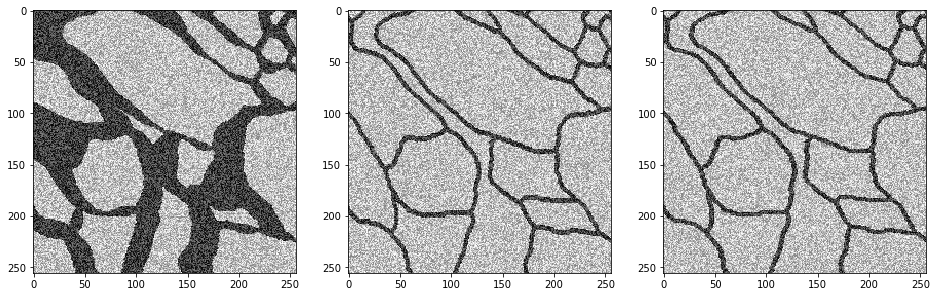

Re-using already compiled waterz version
Preparing segmentation volume...
(26, 256, 256) {'V_Rand_split': 0.9999960954913258, 'V_Rand_merge': 0.09816396174204572, 'V_Info_split': 2.2832357821300775e-05, 'V_Info_merge': 3.8745685388049727}
2


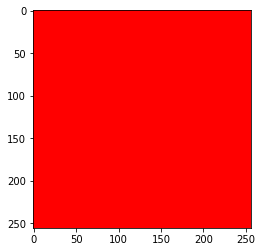

In [10]:
from waterz import agglomerate
import numpy as np

i = 5

patch = dataset.random_training_patch
affinity = patch.affinity
label = patch.label

# affs is a [3, z, y, x] numpy array of float32
affs = np.flip(affinity, axis=0)
affs = np.ascontiguousarray(affs, dtype=np.float32) 

ground_truth = np.ascontiguousarray(label[0], dtype=np.uint32) 
thresholds = [0.9]

affs += np.random.rand(*affs.shape)
view_affinity(affs,i=i)
seg_generator = agglomerate(affs, thresholds, gt=ground_truth,
       aff_threshold_low=0.1,
        aff_threshold_high=0.9,
        return_merge_history=True,
        return_region_graph=False)

for seg, metrics, merge_history in seg_generator:
        print(seg.shape, metrics)
        print(len(np.unique(seg)))
        plt.imshow(seg[i], cmap='prism')
        plt.show()


In [ ]:
from waterz import agglomerate
import numpy as np
from neutorch.cremi.neuron_ids import NeuronIds
import math

def get_agglo(affs, thresholds):

    print(affs.shape, affs.dtype)
    # flip so affinity channel is z,y,x NOT x,y,z
    affs = np.flip(affs, axis=0)
    affs = np.ascontiguousarray(affs, dtype=np.float32) 

    seg_generator = agglomerate(affs, thresholds,
            aff_threshold_low=0.001,
            aff_threshold_high=0.999,
            return_merge_history=False,
            return_region_graph=False)

    res = []
    for seg in seg_generator:
        cur = seg.copy()
        res.append(cur)

    return res


def cremi_test(test, truth, border_threshold):
    neuron_ids_evaluation = NeuronIds(truth, border_threshold=border_threshold)
    (voi_split, voi_merge) = neuron_ids_evaluation.voi(test)
    adapted_rand = neuron_ids_evaluation.adapted_rand(test)
    cremi_score = math.sqrt((voi_split + voi_merge) * adapted_rand) # the geometric mean of (VOI split + VOI merge) and ARAND.
    
    print(f'voi_split: {voi_split}, voi_merge: {voi_merge}, adapted_rand: {adapted_rand}')
    print(f'CREMI score: {cremi_score}')



In [3]:
patch = dataset.random_training_patch

affinity = patch.affinity
truth = np.squeeze(patch.label).astype(np.uint64)

thresholds = [0.1,0.7,1,10]
view_affinity(affinity)
tests = get_agglo(affinity, thresholds)

i=0
plt.imshow(truth[i], cmap='prism')
plt.show()
print(len(np.unique(truth)))
for test in tests:
    print(len(np.unique(test)))
    plt.imshow(test[i], cmap='prism')
    plt.show()
    cremi_test(test, truth, 1)
    

NameError: name 'dataset' is not defined

In [5]:
from neutorch.dataset.affinity import TestDataset
from neutorch.dataset.utils import from_h5
import numpy as np

dataset = TestDataset('../../data/sample_A_pad.hdf', (26,256,256), with_label=True)
label = dataset.label
(sz, sy, sx) = label.shape
(oz, oy, ox) = dataset.label_offset

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits

loading from ../../data/sample_A_pad.hdf...


In [6]:
from neutorch.dataset.border_mask import create_border_mask
mask_size = 2
# add background mask
masked_label = np.zeros(label.shape, dtype=np.uint64)
create_border_mask(label, masked_label, 2, 0)
label = masked_label

In [7]:
t_classes, t_counts = np.unique(label, return_counts=True)
print(len(t_classes))

t_counts.sort()

9120


[       1        1        1 ...  2205764  2329106 27842743]
1703936


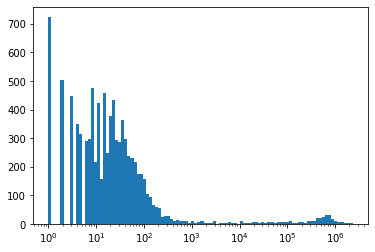

In [8]:
import matplotlib.pyplot as plt
import numpy as np


def plot_loghist(x, bins):
  hist, bins = np.histogram(x, bins=bins)
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x, bins=logbins)
  plt.xscale('log')



print(t_counts)
print(26*256*256)
filtered = list(filter(lambda x: x>10, t_counts))

plot_loghist(t_counts[:-1],100)
plt.show()



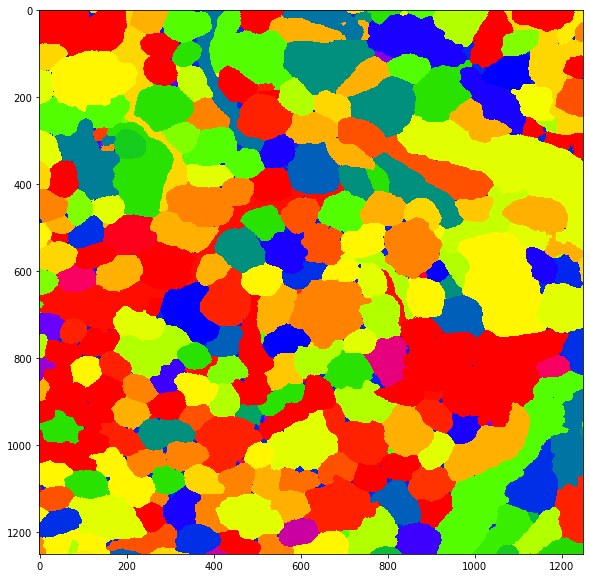

In [39]:
plt.rcParams['image.interpolation'] = 'nearest'
fig = plt.figure()
fig.set_size_inches(10, 10)
i=10
plt.imshow(label[i], cmap='prism')
plt.show()